Importy bibliotek

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import hamming_loss, f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import multilabel_confusion_matrix
from skmultilearn.model_selection import iterative_train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns


Wczytanie i wstępne przetwarzanie danych

In [2]:
FILE = 'data/stan_ustalony.csv'

# Lista cech
SELECTED_FEATURES = [
    'Active Power 1 (Cycle) [W]',
    'Reactive Power 1 (Cycle) [VAr]',
    'Power Factor 1 (Cycle) (Load)',
    'RMS - non-Fundamental I1 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]',
]

# Urzadzenia
DEVICE_COLUMNS = [
    'kettle', 
    'tv',
    'coffee_maker', 
    'immersion_heater',
    'aquarium_heater', 
    'heater',
    'laptop', 
    'christmas_tree', 
    'timer',
    'fridge', 
    'Monitor',
]

# Wczytanie csv
df = pd.read_csv(FILE, sep=';', decimal=',')
df = df.iloc[:, :120]
# Usuwanie CAP/IND z Power Factor
def clean_power_factor(value):
    if isinstance(value, str):
        value = value.replace(' CAP', '').replace(' IND', '').strip()
        value = value.replace(',', '.')
    return value

# Czyszczenie powerfactor
PF_COLS = [col for col in SELECTED_FEATURES if 'Power Factor' in col]
for col in PF_COLS:
    df[col] = df[col].apply(clean_power_factor)

# Konwersja cech na typ numeryczny
for col in SELECTED_FEATURES:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Wiersze przed czyszczeniem
print(f"Liczba wierszy przed czyszczeniem: {len(df)}")

Liczba wierszy przed czyszczeniem: 1316


Inżynieria cech - Teoria mocy Fryzego i Budeanu

In [3]:
# Zmienne dla nowych cech
col_v = 'RMS V1N (Cycle) [V]'
col_i = 'RMS I1 (Cycle) [A]'
col_p = 'Active Power 1 (Cycle) [W]'
col_q = 'Reactive Power 1 (Cycle) [VAr]'

# Sprawdzenie czy kolumny sa numeryczne
for col in [col_v, col_i, col_p, col_q]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Moc pozorna
df['S_total_calc'] = df[col_v] * df[col_i]

# Budeanu
# Wzór: D = sqrt(S^2 - P^2 - Q^2)
term_under_sqrt = (df['S_total_calc']**2) - (df[col_p]**2) - (df[col_q]**2)
df['Budeanu Distortion Power [VAr]'] = np.sqrt(np.maximum(term_under_sqrt, 0))

# Fryze

# Konduktancja Czynna (Gw)
# Gw = P / U^2
df['Fryze_Conductance'] = df[col_p] / (df[col_v] ** 2)

# Prąd Czynny Fryzego (Iw)
# Wzór: Iw = Gw * U
df['Fryze_Active_Current'] = df['Fryze_Conductance'] * df[col_v]

# Prąd Bierny Fryzego (Ib)
# Wzór: Ib = sqrt(I_calkowite^2 - Iw^2)
df['Fryze_Passive_Current'] = np.sqrt(np.maximum(df[col_i]**2 - df['Fryze_Active_Current']**2, 0))

# Moc Bierna Fryzego (Pb)
# Wzór: Pb = sqrt(S^2 - P^2)
df['Fryze_Passive_Power'] = np.sqrt(np.maximum(df['S_total_calc']**2 - df[col_p]**2, 0))

# Nowe cechy
NEW_FEATURES = [
    'Budeanu Distortion Power [VAr]',
    'Fryze_Conductance',
    'Fryze_Active_Current',
    'Fryze_Passive_Current',
    'Fryze_Passive_Power'
]

Dodanie cech wynikajacych z teorii mocy Fryzego i Budeanu

In [ ]:
for feature in NEW_FEATURES:
    if feature not in SELECTED_FEATURES:
        SELECTED_FEATURES.append(feature)

print(f"\nLiczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

Usunięcie cech wynikajacych z teorii mocy

In [ ]:
# Usuniecie cech wynikajacych z teorii mocy
for feature in NEW_FEATURES:
    if feature in SELECTED_FEATURES:
        SELECTED_FEATURES.remove(feature)
print(f"\nLiczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

Czyszczenie danych i podział na zbiory treningowy, walidacyjny i testowy

In [4]:
# Zastapienie Inf/ -Inf na NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Zamiana NaN na 0
df[SELECTED_FEATURES] = df[SELECTED_FEATURES].fillna(0)

print(f"Wartości NaN/Inf zastąpiono zerami.")
print(f"Liczba wierszy: {len(df)}")

if len(df) == 0:
    raise ValueError("Zbiór danych jest pusty")

# Przygotowanie macierzy cech (X) i etykiet (y)
for col in DEVICE_COLUMNS:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

X = df[SELECTED_FEATURES].values
y = df[DEVICE_COLUMNS].values

# Wydzielenie zbioru testowego
X_temp, y_temp, X_test, y_test = iterative_train_test_split(X, y, test_size=0.20)

# Wydzielenie zbioru walidacyjnego
X_train, y_train, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size=0.15)

# Standaryzacja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("-" * 30)
print(f"Wymiary Trening:   {X_train_scaled.shape}, y: {y_train.shape}")
print(f"Wymiary Walidacja: {X_val_scaled.shape}, y: {y_val.shape}")
print(f"Wymiary Test:      {X_test_scaled.shape}, y: {y_test.shape}")
print(f"Liczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

Wartości NaN/Inf zastąpiono zerami.
Liczba wierszy: 1316
------------------------------
Wymiary Trening:   (894, 6), y: (894, 11)
Wymiary Walidacja: (158, 6), y: (158, 11)
Wymiary Test:      (264, 6), y: (264, 11)
Liczba cech: 6
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]']


Wyswietlenie wektorów cech

In [ ]:
all_features_scaled = np.vstack((X_train_scaled, X_val_scaled, X_test_scaled))
features_df = pd.DataFrame(all_features_scaled, columns=SELECTED_FEATURES)

print(f"Łączna liczba wektorów cech: {len(features_df)}")
display(features_df)

Rozkład próbek na urządzenia w zbiorach danych

In [ ]:

check_df = pd.DataFrame({
    'Device': DEVICE_COLUMNS,
    'Train': y_train.sum(axis=0),
    'Val': y_val.sum(axis=0),
    'Test': y_test.sum(axis=0),
    'Total': y_train.sum(axis=0) + y_val.sum(axis=0) + y_test.sum(axis=0)
})
display(check_df.sort_values(by='Train', ascending=False))

Wyświetlenie podsumowania zbiorów danych

In [5]:
total_counts = y_train.sum(axis=0) + y_val.sum(axis=0) + y_test.sum(axis=0)
total_samples = 1316

summary_df = pd.DataFrame({
    'Nazwa urządzenia': DEVICE_COLUMNS,
    'Ilość próbek': total_counts,
    'Wkład %': (total_counts / total_samples) * 100
})

summary_df = summary_df.sort_values(by='Ilość próbek', ascending=False)
summary_df['Wkład %'] = summary_df['Wkład %'].map('{:.2f}%'.format)

display(summary_df)

import pandas as pd

total_samples = len(X_train) + len(X_val) + len(X_test)

data_summary = {
    'Zbiór danych': ['Treningowy', 'Walidacyjny', 'Testowy'],
    'Przeznaczenie': [
        'Dopasowanie wag sieci MLP i parametrów modelu RF',
        'Monitorowanie procesu uczenia MLP i strojenie parametrów',
        'Końcowa ewaluacja jakości klasyfikacji'
    ],
    'Liczba próbek': [len(X_train), len(X_val), len(X_test)],
    'Udział procentowy': [
        f"{(len(X_train)/total_samples):.0%}",
        f"{(len(X_val)/total_samples):.0%}",
        f"{(len(X_test)/total_samples):.0%}"
    ]
}

df_summary = pd.DataFrame(data_summary)

display(df_summary)

,Zbiór danych,Przeznaczenie,Liczba próbek,Udział procentowy
0,Treningowy,Dopasowanie wag sieci MLP i parametrów modelu RF,894,68%
1,Walidacyjny,Monitorowanie procesu uczenia MLP i strojenie ...,158,12%
2,Testowy,Końcowa ewaluacja jakości klasyfikacji,264,20%


Random Forest

In [6]:
# Konfiguracja modelu
#rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_model = RandomForestClassifier(
    n_estimators=320,        # większa liczba drzew
    max_depth=25,            # zmniejszona glebokosc
    min_samples_split=5,     # wezel musi miec min 5 probek do podzialu
    min_samples_leaf=2,      # lisc min 2 probki
    class_weight='balanced', # wieksze wagi dla mniejszościowych klas
    n_jobs=-1,               # Użycie wszystkich rdzeni CPU
    random_state=42
)

# Dopasowanie modelu do danych treningowych
rf_model.fit(X_train_scaled, y_train)
print("Koniec treningu Random Forest.")

# Predykcja na zbiorze testowym
y_pred = rf_model.predict(X_test_scaled)

rf_hamming = hamming_loss(y_test, y_pred)
rf_f1_samples = f1_score(y_test, y_pred, average='samples', zero_division=1)
rf_f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=1)
rf_exact_match = accuracy_score(y_test, y_pred)
print(f"F1-Score (Samples):            {rf_f1_samples:.2%}")
print(f"F1-Score (Micro):              {rf_f1_micro:.2%}")
print(f"Hamming Loss:                  {rf_hamming:.4f}")

print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=DEVICE_COLUMNS, zero_division=0))

Koniec treningu Random Forest.
F1-Score (Samples):            86.76%
F1-Score (Micro):              85.11%
Hamming Loss:                  0.0506
Raport klasyfikacji:
                  precision    recall  f1-score   support

          kettle       0.87      0.81      0.84        16
              tv       0.87      0.84      0.85       130
    coffee_maker       0.92      0.80      0.86        45
immersion_heater       0.79      0.92      0.85        12
 aquarium_heater       1.00      1.00      1.00        35
          heater       0.78      0.81      0.79        36
          laptop       0.70      0.57      0.63        58
  christmas_tree       1.00      1.00      1.00        35
           timer       0.83      0.95      0.88        20
          fridge       0.87      0.95      0.91        78
         Monitor       0.72      0.84      0.78        31

       micro avg       0.86      0.85      0.85       496
       macro avg       0.85      0.86      0.85       496
    weighted avg    

Multi layer Perceptron (Neural Network)

In [ ]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Dostępne urządzenia: {tf.config.list_physical_devices()}")

input_dim = X_train_scaled.shape[1]
output_dim = y_train.shape[1]

model = models.Sequential([
    # Warstwa wejściowa -> Ukryta 1
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3), 
    
    # Ukryta 1 -> Ukryta 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    
    # Warstwa wyjściowa
    layers.Dense(output_dim)
])

# podsumowanie architektury modelu
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

EPOCHS = 150
BATCH_SIZE = 32

print("Rozpoczynam trening sieci neuronowej (TensorFlow)...")

history = model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)



# Predykcja zwraca "logits" (surowe wartości)
logits = model.predict(X_test_scaled)

# Konwersja logits -> prawdopodobieństwa (Sigmoid)
probs = tf.nn.sigmoid(logits).numpy()

# Binaryzacja wyników (Próg 0.5)
y_pred_numpy = (probs > 0.5).astype(int)

# Raport wyników
acc_dnn = accuracy_score(y_test, y_pred_numpy)

mlp_f1_samples = f1_score(y_test, y_pred_numpy, average='samples', zero_division=1)
mlp_f1_micro = f1_score(y_test, y_pred_numpy, average='micro', zero_division=1)
mlp_hamming = hamming_loss(y_test, y_pred_numpy)

print(f"F1-Score (Samples):            {mlp_f1_samples:.2%}")
print(f"F1-Score (Micro):              {mlp_f1_micro:.2%}")
print(f"Hamming Loss:                  {mlp_hamming:.4f}")

print("Szczegółowy raport klasyfikacji:")
print(classification_report(y_test, y_pred_numpy, target_names=DEVICE_COLUMNS, zero_division=0))

Wykres funkcji straty podczas treningu sieci neuronowej

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Przebieg uczenia (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Loss (BCE)')
plt.legend()
plt.grid(True)
plt.show()

Accuracy dla poszczególnych urządzeń

In [ ]:
def print_per_device_accuracy(y_true, y_pred, labels, model_name="Model"):
    print(f"\n=== Accuracy dla poszczególnych urządzeń ({model_name}) ===")
    
    accuracies = {}
    
    for i, device in enumerate(labels):
        acc = accuracy_score(y_true[:, i], y_pred[:, i])
        accuracies[device] = acc
        print(f"{device}: {acc:.2%}")
        
    return accuracies

# Accuracy poszczegylnych urządzeń dla Random Forest
print_per_device_accuracy(y_test, y_pred, DEVICE_COLUMNS, model_name="Random Forest")


# Accuracy poszczegolnych urzadzen dla MLP (Sieć Neuronowa)
print_per_device_accuracy(y_test, y_pred_numpy, DEVICE_COLUMNS, model_name="MLP")

Funkcję do wizualizacji macierzy pomyłek i mapy ciepła korelacji urządzeń

In [8]:
def plot_individual_confusion_matrices(y_true, y_pred, labels, model_name):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    n_labels = len(labels)
    cols = 3
    rows = (n_labels + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()
    for i in range(n_labels):
        sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'Urządzenie: {labels[i]}')
        axes[i].set_xticklabels(['OFF', 'ON']); axes[i].set_yticklabels(['OFF', 'ON'])
        axes[i].set_xlabel('Przewidziane'); axes[i].set_ylabel('Rzeczywiste')
    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.suptitle(f'Macierze pomyłek - {model_name}', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_multilabel_heatmap(y_true, y_pred, labels, title, cmap='YlGnBu'):
    n_labels = len(labels)
    conf_matrix = np.zeros((n_labels, n_labels))

    for i in range(n_labels):
        actual_i_on = (y_true[:, i] == 1)

        if np.any(actual_i_on):
            for j in range(n_labels):
                if i == j:
                    conf_matrix[i, j] = np.sum((y_pred[actual_i_on, i] == 1))
                else:
                    conf_matrix[i, j] = np.sum((y_pred[actual_i_on, j] == 1) & (y_true[actual_i_on, j] == 0))

    plt.figure(figsize=(14, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap=cmap,
                xticklabels=labels, yticklabels=labels)

    plt.title(title, fontsize=14)
    plt.xlabel('Przewidziane urządzenia', fontsize=12)
    plt.ylabel('Faktycznie działające urządzenia (Prawda)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Wizualizacja wyników dla MLP (Sieć Neuronowa)

In [ ]:
plot_multilabel_heatmap(
    y_test,
    y_pred_numpy,
    DEVICE_COLUMNS,
    "Mapa ciepła korelacji urządzeń - MLP (Neural Network)",
    cmap='YlGnBu'
)

In [ ]:
plot_individual_confusion_matrices(
    y_test,
    y_pred_numpy,
    DEVICE_COLUMNS,
    model_name="MLP (Neural Network)"
)

Wizualizacja wyników dla Random Forest

In [ ]:
plot_multilabel_heatmap(
    y_test,
    y_pred,
    DEVICE_COLUMNS,
    "Mapa ciepła korelacji urządzeń - Random Forest",
    cmap='YlGnBu'
)

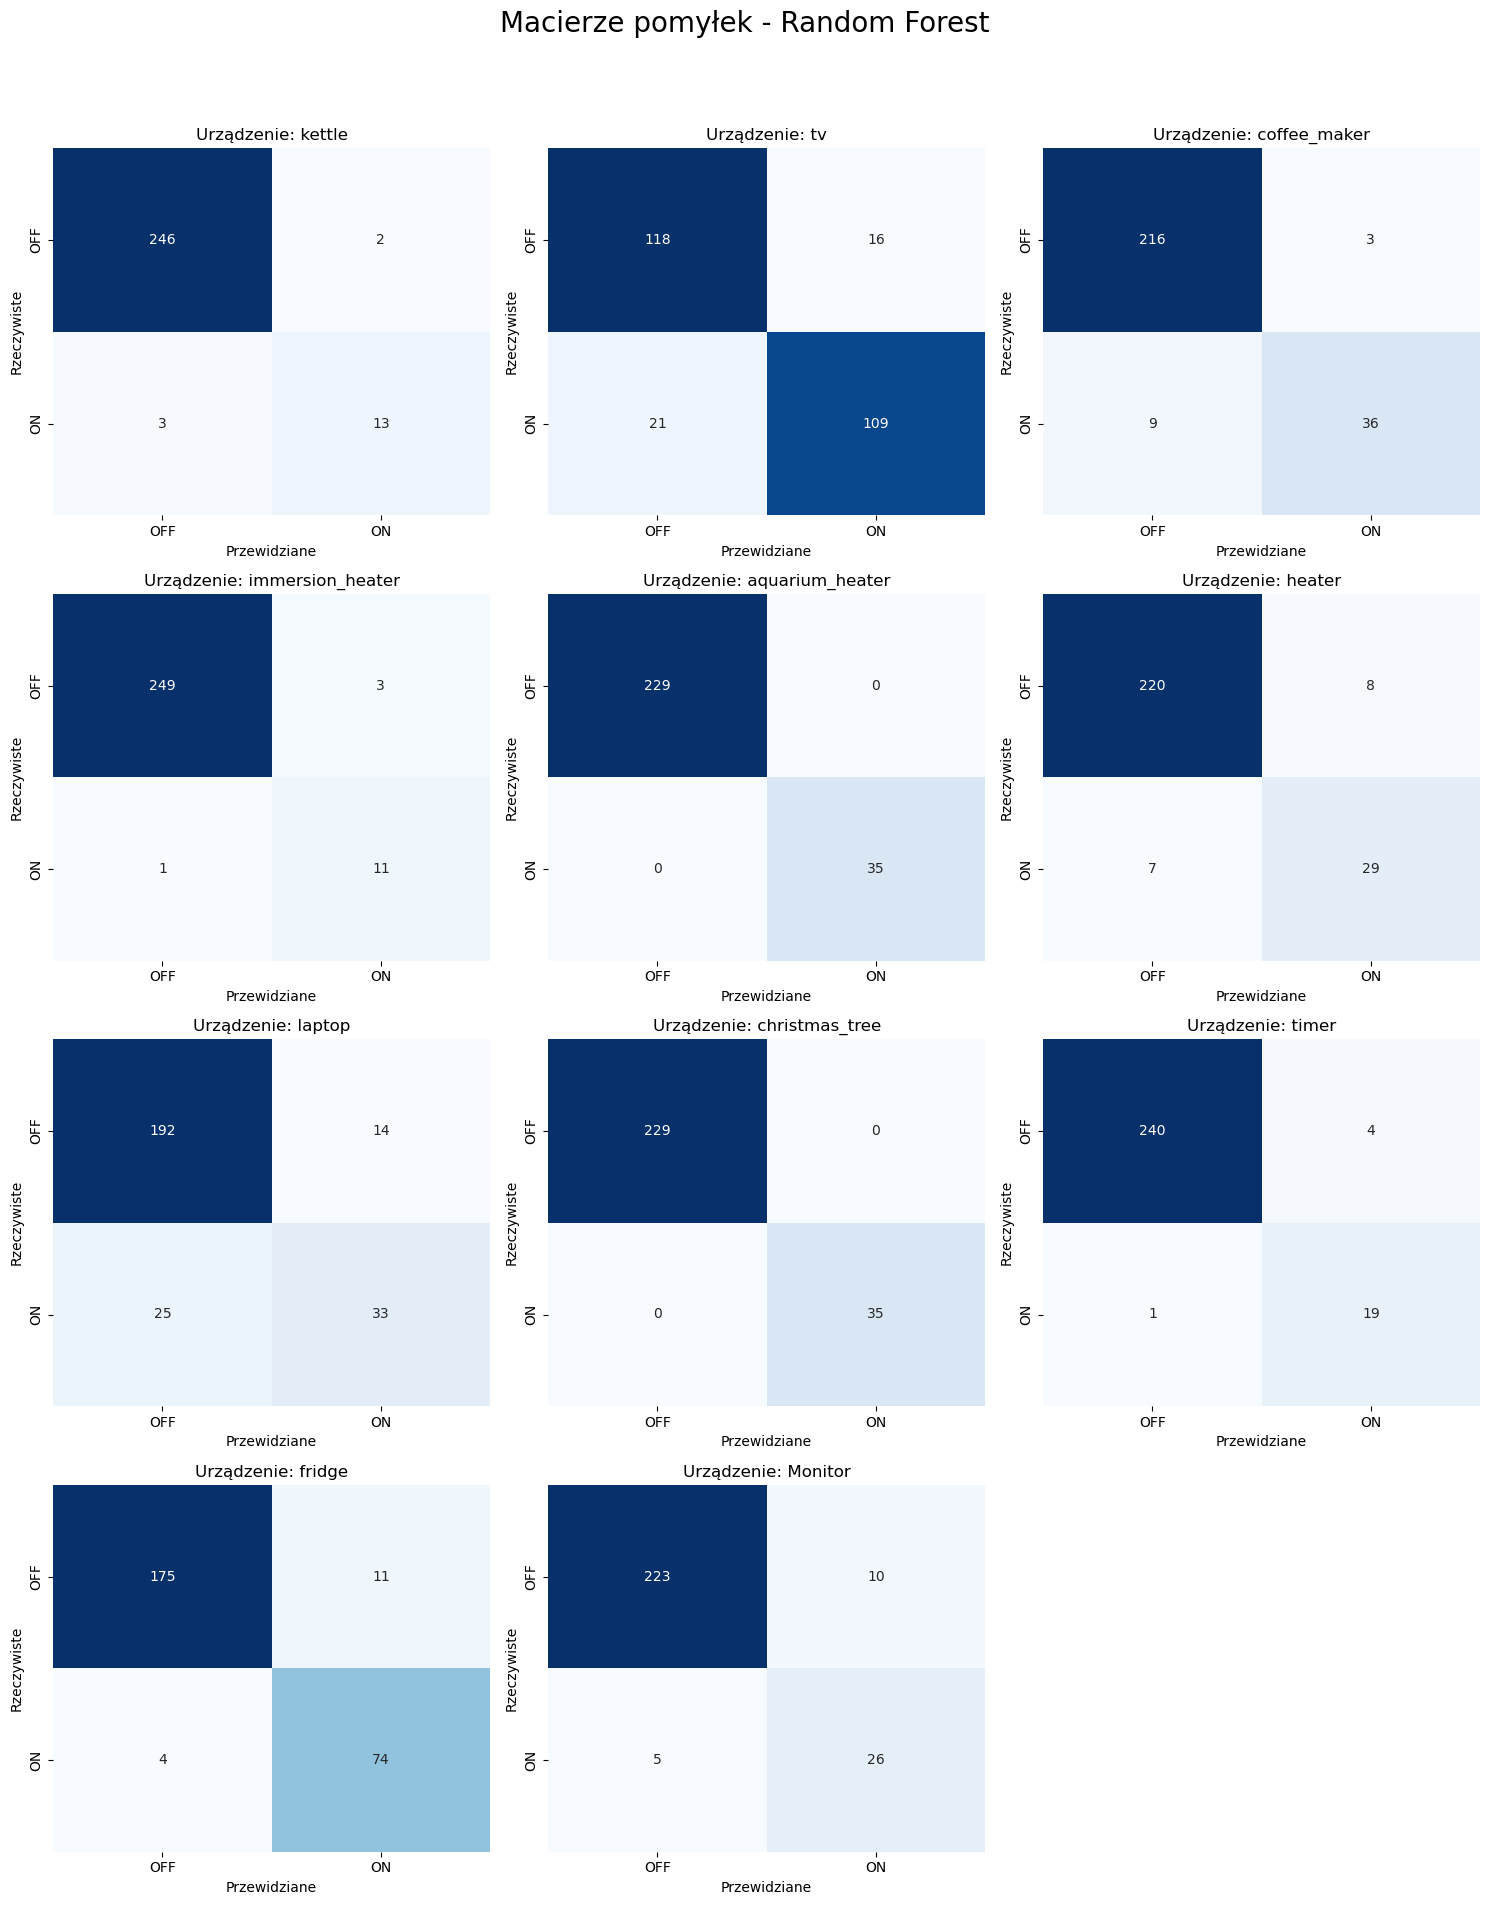

In [9]:
plot_individual_confusion_matrices(
    y_test,
    y_pred,
    DEVICE_COLUMNS,
    model_name="Random Forest"
)

Wykres słupkowy porównujący F1-score dla Random Forest i MLP (Sieć Neuronowa)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

devices = [
    'kettle', 'tv', 'coffee_maker', 'immersion_heater', 'aquarium_heater',
    'heater', 'laptop', 'christmas_tree', 'timer', 'fridge', 'Monitor'
]

# Wartości F1-score z Twoich raportów
rf_f1 = [0.84, 0.87, 0.82, 0.85, 1.00, 0.81, 0.64, 1.00, 0.84, 0.90, 0.79]
mlp_f1 = [0.83, 0.73, 0.79, 0.86, 1.00, 0.83, 0.44, 1.00, 0.79, 0.83, 0.70]

x = np.arange(len(devices))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, rf_f1, width, label='Random Forest', color='#3498db', edgecolor='black', alpha=0.8)
rects2 = ax.bar(x + width/2, mlp_f1, width, label='MLP (Sieć Neuronowa)', color='#e74c3c', edgecolor='black', alpha=0.8)

ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Porównanie skuteczności (F1-Score) per urządzenie', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(devices, rotation=45, ha='right', fontsize=11)
ax.set_ylim(0, 1.15)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.6)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('porownanie_f1_rf_mlp.png', dpi=300)
plt.show()